In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier

# Module Functions

In [38]:
def getPurity(labels,method = 'IGain'):
    """
    Calculates purity for binary classification with labels 0/1 or True/False .
    
    Parameters
    ----------
    labels : 
    
    Returns
    ----------
    
    """
    tot_0 = float(len(labels[labels == 0]))
    tot_1 = float(len(labels[labels == 1]))
    L = float(tot_0 + tot_1)
    
    if(tot_0==0 or tot_1==0):
        return 0
    
    if method == 'Gini':
        return 1-(tot_0**2 + tot_1**2)/L**2
    else:
        # Default is Information Gain
        return -np.dot(np.array([tot_0/L,tot_1/L]) , np.log2([tot_0/L,tot_1/L]))
    

def getBestSplit(features, labels,method = 'IGain'):
    """
    Find the best feature, split level, and corresponding deviance associated 
    with the provided labels.
    
    Parameters
    ----------
    features : 
    
    labels :
    
    Returns
    ----------
    tuple
        
    """
    
    #print('Features: %s' % features.ndim)

    
    best_feat = -1
    best_split = -1
    best_purity = 1.0
    
    curr_feat = -1
    curr_split = -1 
    curr_purity = 1.0
    
    splitA_idx = []
    splitB_idx = []
    
    features_1D = (features.ndim==1)
    
    loop_max = 0
    if features_1D:
        loop_max = 1
    else:
        loop_max = features.shape[1]
    
    for i in range(loop_max):
        curr_feat = i
        
        if features_1D:
            quants = np.percentile(features[:],[10,20,30,40,50,60,70,80,90])
        else:
            quants = np.percentile(features[:,i],[10,20,30,40,50,60,70,80,90])

        for j in quants:
            curr_split = j
            
            if features_1D:
                splitA_idx = np.argwhere(features[:]<curr_split).ravel()
                splitB_idx = np.argwhere(features[:]>=curr_split).ravel()
            else:
                splitA_idx = np.argwhere(features[:,i]<curr_split).ravel()
                splitB_idx = np.argwhere(features[:,i]>=curr_split).ravel()
            
            #Average Deviance of Daughter Nodes
            curr_purityA =  0.5*getPurity(labels[splitA_idx],method = method) 
            curr_purityB =  0.5*getPurity(labels[splitB_idx],method = method)
            curr_purity = curr_purityA + curr_purityB
            
            if(curr_purity < best_purity):
                best_feat = curr_feat
                best_split = curr_split
                best_purity = curr_purity
    
    return (best_feat, best_split, best_purity)
 
    
    
def optimal_splitting(features, labels, min_split_size = 10, main_feat = 1, current_depth = 1,max_depth = 2,method='IGain'):
    """
    Generates a hierarchical output with the heights, deviances, and sample sizes present
    when the target feature is used as a split node in a tree.
    
    Parameters
    ----------
    features : numpy ndarray
    
    labels : numpy array
    
    min_split_size : int
    
    main_feat : int
    
    current_depth : int
    
    max_depth : int
    
    Returns
    ----------
    list
        
    """
    
    temp = []
    split_lower_idx = []
    split_upper_idx = []
    occur_depth = []

    #Return -1 for split deviance if labels is pure, too small, or NULL (Degenerate Case)
    if (len(np.unique(labels))<2) or (len(labels)<min_split_size):
        return [(current_depth, -1,len(labels),len(np.unique(labels)))]
    
    #Execute Recursive Split if Less Than Max Depth & Above Min Sample Size 
    if(len(labels)>min_split_size and current_depth <max_depth):    
        temp = getBestSplit(features,labels)
        
        if temp[0]==main_feat:
            occur_depth = [(current_depth, temp[2],len(labels),len(np.unique(labels)))]
       
        #Split the input data and labels using the best split and best level
        split_lower_idx = np.argwhere(features[:,temp[0]]<=temp[1]).ravel()
        split_upper_idx = np.argwhere(features[:,temp[0]]>temp[1]).ravel()    
        
        return [optimal_splitting(features = features[split_lower_idx,:]
                             , labels = labels[split_lower_idx]
                             , min_split_size= min_split_size
                             , main_feat = main_feat
                             , current_depth = current_depth+1
                             , max_depth = max_depth
                             , method = method)
                ,optimal_splitting(features = features[split_upper_idx,:]
                             , labels = labels[split_upper_idx]
                             , min_split_size= min_split_size
                             , current_depth = current_depth+1
                             , max_depth = max_depth
                             , method = method)
                , occur_depth]    
    else:
        #At Max Depth OR Insufficient Sample Size
        temp = getBestSplit(features[:,main_feat],labels, method = method)     
        return [(current_depth, temp[2],len(labels),len(np.unique(labels)))]

def flatten_score_list(score_list):
    """
    Converts the hierarchical output from optimal_splitting into a
    list of tuples.
    
    Parameters
    ----------
    score_list :
    
    Returns
    ----------
    list
        Node depth, , ,Number of Unique Labels
    """
    if (len(score_list)==2):
        return flatten_score_list(score_list[0])\
                + flatten_score_list(score_list[1])
    elif (len(score_list)==3):
        return flatten_score_list(score_list[0])\
                + flatten_score_list(score_list[1])\
                + flatten_score_list(score_list[2])
    else:
        return score_list


# Performance Testing
---

### Section 1: Test Split Identification [Good]

The column order affects the optimal feature choice in the case of ties. 

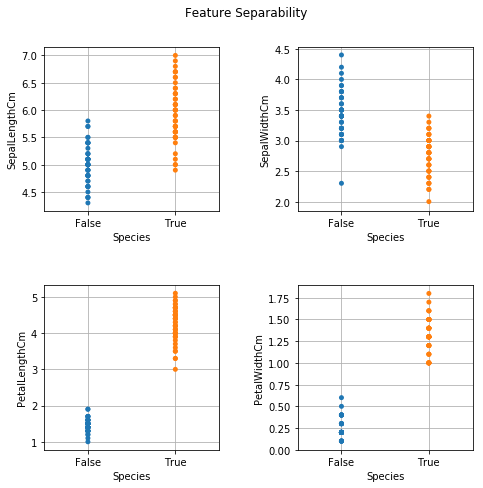

['SepalLengthCm' 'SepalWidthCm' 'PetalLengthCm' 'PetalWidthCm']
Best Identified Splitting Feature: "PetalLengthCm"
Associated Splitting Value: 2.45
Associated Purity: 0.0

['SepalLengthCm' 'SepalWidthCm' 'PetalWidthCm' 'PetalLengthCm']
Best Identified Splitting Feature: "PetalWidthCm"
Associated Splitting Value: 0.8
Associated Purity: 0.0


In [35]:
DF = pd.read_csv('Iris_reduced.csv')
DF['Species'] = (DF['Species'].values=='Iris-versicolor')
species = DF['Species'].values
#DF = DF.drop(['Species'],axis = 1)

DF_mat = DF.as_matrix()
labels = species

plt.figure(figsize=(7,7))

plt.suptitle('Feature Separability')

plt.subplot(2, 2, 1)
sns.stripplot(y='SepalLengthCm',x='Species',data =DF)
plt.grid()

plt.subplot(2, 2, 2)
sns.stripplot(y='SepalWidthCm',x='Species',data = DF)
plt.grid()

plt.subplot(2, 2, 3)
sns.stripplot(y='PetalLengthCm',x='Species',data=DF)
plt.grid()

plt.subplot(2, 2, 4)
sns.stripplot(y='PetalWidthCm',x='Species',data=DF)
plt.grid()

plt.subplots_adjust(top=0.9  , bottom=0.1, left=0.10
                    , right=0.95 , hspace=0.45 , wspace=0.45)
plt.show()

print DF.columns.values[0:4]
temp = getBestSplit(DF_mat,labels=labels)
print('Best Identified Splitting Feature: "%s"' % DF.columns[temp[0]])
print('Associated Splitting Value: %s' % temp[1])
print('Associated Purity: %s' % temp[2])

DF = DF[['SepalLengthCm','SepalWidthCm','PetalWidthCm','PetalLengthCm']]
DF_mat = DF.as_matrix()
temp = getBestSplit(DF_mat,labels=labels)
print('')
print DF.columns.values
print('Best Identified Splitting Feature: "%s"' % DF.columns[temp[0]])
print('Associated Splitting Value: %s' % temp[1])
print('Associated Purity: %s' % temp[2])

### Section 2: Baseline Testing [Good]

In [39]:
# Testing On Iris Dataset because of linear separability
DF = pd.read_csv('Iris_reduced.csv')
DF['Species'] = (DF['Species'].values=='Iris-versicolor')
species = DF['Species'].values
DF = DF.drop(['Species'],axis = 1)

DF_mat = DF.as_matrix()
labels = species

# Loop Parameters
start = 0
max_depth = 2

for l in range(max_depth):
    # Feature Loop
    runtime = []
    output = []
    print('\n-- Max Tree Depth: %s --' % (l+1))

    for i in range(len(DF.columns)):
        start = time.time()
        temp =optimal_splitting(features=DF_mat
                        , labels = labels
                        , min_split_size = 10
                        , main_feat = i
                        , max_depth = l+1
                        , method = 'IGain'
                        )
        runtime.append(time.time()-start)
        output.append(temp)

    for i in range(4):
        print('Feature: %s' % DF.columns[i])
        print('\tRuntime: %s' % runtime[i])
        print('\tNode Split Locations:' + str(output[i]))


-- Max Tree Depth: 1 --
Feature: SepalLengthCm
	Runtime: 0.00128197669983
	Node Split Locations:[(1, 0.47721700146248253, 100, 2)]
Feature: SepalWidthCm
	Runtime: 0.000894069671631
	Node Split Locations:[(1, 0.4742051946744007, 100, 2)]
Feature: PetalLengthCm
	Runtime: 0.000500917434692
	Node Split Locations:[(1, 0.0, 100, 2)]
Feature: PetalWidthCm
	Runtime: 0.000486135482788
	Node Split Locations:[(1, 0.0, 100, 2)]

-- Max Tree Depth: 2 --
Feature: SepalLengthCm
	Runtime: 0.00346803665161
	Node Split Locations:[[(2, -1, 50, 1)], [(2, -1, 50, 1)], []]
Feature: SepalWidthCm
	Runtime: 0.0026228427887
	Node Split Locations:[[(2, -1, 50, 1)], [(2, -1, 50, 1)], []]
Feature: PetalLengthCm
	Runtime: 0.00198078155518
	Node Split Locations:[[(2, -1, 50, 1)], [(2, -1, 50, 1)], [(1, 0.0, 100, 2)]]
Feature: PetalWidthCm
	Runtime: 0.00196099281311
	Node Split Locations:[[(2, -1, 50, 1)], [(2, -1, 50, 1)], []]


### Section 3: Runtime vs Depth [Good]

Max Split Depth: 1 , Runtime: 0.000780820846558
Max Split Depth: 2 , Runtime: 0.0216319561005
Max Split Depth: 3 , Runtime: 0.05757188797
Max Split Depth: 4 , Runtime: 0.0937550067902
Max Split Depth: 5 , Runtime: 0.122732877731
Max Split Depth: 6 , Runtime: 0.149122953415
Max Split Depth: 7 , Runtime: 0.189270019531
Max Split Depth: 8 , Runtime: 0.23840880394
Max Split Depth: 9 , Runtime: 0.26220703125
Max Split Depth: 10 , Runtime: 0.287564992905


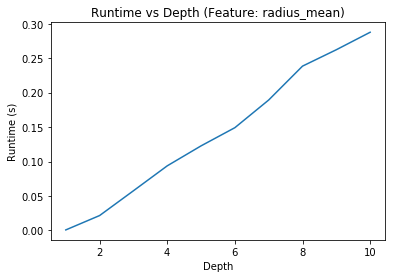

In [40]:
DF = pd.read_csv('data.csv')
DF = DF.iloc[:,:-1]
DF['diagnosis'] = (DF['diagnosis'].values=='M')

diag = DF['diagnosis'].values
DF = DF.drop(['id','diagnosis'],axis = 1)

DF_mat = DF.as_matrix()
labels = diag

#Loop Parameters
start = 0
max_depth = 10
main_feature = 0

runtime = []
results = []
#Depth loop
for i in np.arange(1,max_depth+1): 
    start = time.time()
    a=optimal_splitting(features=DF_mat
                        , labels = labels
                        , min_split_size = 10
                        , main_feat = main_feature
                        , max_depth = i)
    runtime.append(time.time()-start)

    results.append(a)
    print('Max Split Depth: %s , Runtime: %s' %(i,runtime[-1]))

plt.plot(np.arange(1,max_depth+1),runtime)
plt.title('Runtime vs Depth (Feature: %s)' % DF.columns[main_feature])
plt.xlabel('Depth')
plt.ylabel('Runtime (s)')
plt.show()

del DF
del diag
del DF_mat
del labels
del results
del runtime

### Section 4: Bootstrap Samples [Double Check]

In [42]:
DF = pd.read_csv('data.csv')
DF = DF.iloc[:,:-1]
DF['diagnosis'] = (DF['diagnosis'].values=='M')

diag = DF['diagnosis'].values
DF = DF.drop(['id','diagnosis'],axis = 1)

DF_mat = DF.as_matrix()
labels = diag

start = 0
max_depth = 9
trees_count = 10
target_feature = 0
results = []
#Depth loop
print('Performing Bootstrapping Process for "%s"' % (DF.columns[target_feature]))

start = time.time()
for i in np.arange(1,trees_count): 
    #Select Random Rows with Replacement
    bootstrapped_rows = np.random.randint(low=0,high = len(diag),size=len(diag))
    bootstrapped_feats = DF_mat[bootstrapped_rows,:]
    bootstrap_labels = diag[bootstrapped_rows]
    
    a=optimal_splitting(bootstrapped_feats
                        ,bootstrap_labels
                        ,main_feat=target_feature
                        ,max_depth = max_depth
                        ,method = 'IGain')
    results.append(a)

print('Total Runtime: %s seconds ' % (time.time()-start))

Performing Bootstrapping Process for "radius_mean"
Total Runtime: 2.21990203857 seconds 


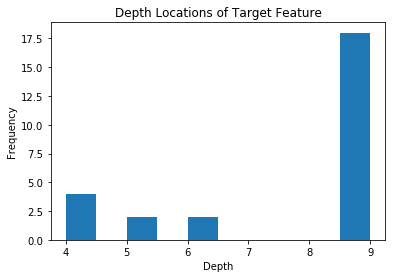

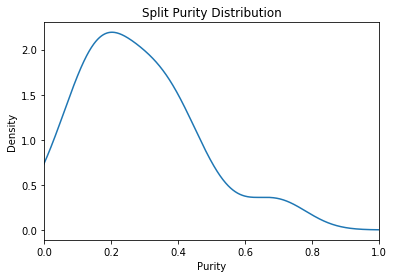

In [43]:
flattened_results = []

for i in results:
    flattened_results=flattened_results +flatten_score_list(i)

compiled_results_df = pd.DataFrame.from_records(flattened_results,columns = ['Depth','Purity','SampleSize','Levels'])

a=compiled_results_df.loc[compiled_results_df['Purity']>-1]

a['Depth'].plot('hist')
plt.xlabel('Depth')
plt.title('Depth Locations of Target Feature')
plt.show()

a['Purity'].plot('kde')
plt.xlim(0,1)
plt.title('Split Purity Distribution')
plt.xlabel('Purity')
plt.show()

del DF
del diag
del DF_mat
del labels
del results

## Compare to Random Forest Model
---

In [45]:
DF = pd.read_csv('data.csv')
DF = DF.iloc[:,:-1]
DF['diagnosis'] = (DF['diagnosis'].values=='M')

diag = DF['diagnosis'].values
DF = DF.drop(['id','diagnosis'],axis = 1)

DF_mat = DF.as_matrix()
labels = diag

#Scikit Learn Out-of-Box Random Forest - Short Runtime
rf_depth = 5
tree_count = 50
clf = RandomForestClassifier(n_estimators = tree_count,max_depth=rf_depth,max_features=None, random_state=0)
clf.fit(DF_mat, labels)

#Custom Code - Moderate Runtime
start_time = 0
max_depth = 6
trees_count = 50
results = []
temp = []
start_time = time.time()

#Feature Loop
for l in range(len(DF.columns)):
    temp = []
    print('Performing Bootstrapping Process for "%s"' % (DF.columns[l]))
    
    #Tree Loop
    for i in np.arange(1,trees_count): 
        #Select Random Rows with Replacement
        bootstrapped_rows = np.random.randint(low=0,high = len(diag),size=len(diag))
        bootstrapped_feats = DF_mat[bootstrapped_rows,:]
        bootstrap_labels = diag[bootstrapped_rows]

        a=optimal_splitting(bootstrapped_feats,bootstrap_labels,main_feat=l,max_depth = max_depth,method = 'Gini')
        temp.append(a)
    
    results.append(temp)

print('\nTotal Runtime: %s seconds ' % (time.time()-start_time))

Performing Bootstrapping Process for "radius_mean"
Performing Bootstrapping Process for "texture_mean"
Performing Bootstrapping Process for "perimeter_mean"
Performing Bootstrapping Process for "area_mean"
Performing Bootstrapping Process for "smoothness_mean"
Performing Bootstrapping Process for "compactness_mean"
Performing Bootstrapping Process for "concavity_mean"
Performing Bootstrapping Process for "concave points_mean"
Performing Bootstrapping Process for "symmetry_mean"
Performing Bootstrapping Process for "fractal_dimension_mean"
Performing Bootstrapping Process for "radius_se"
Performing Bootstrapping Process for "texture_se"
Performing Bootstrapping Process for "perimeter_se"
Performing Bootstrapping Process for "area_se"
Performing Bootstrapping Process for "smoothness_se"
Performing Bootstrapping Process for "compactness_se"
Performing Bootstrapping Process for "concavity_se"
Performing Bootstrapping Process for "concave points_se"
Performing Bootstrapping Process for "sym

### Post-Processing

In [46]:
# Results P
flats=[]
temp=[]
for i in range(len(results)):
    temp = []
    for j in results[i]:
        temp=temp +flatten_score_list(j)

    flats.append(temp)

flats_dfs_list = []

for i in flats:
    temp = pd.DataFrame.from_records(i,columns = ['Depth','Purity','SampleSize','Levels'])
    temp = temp.iloc[(temp['Purity'].values>-1),:]
    temp = temp.iloc[(temp['Depth'].values<max_depth),:]
    flats_dfs_list.append(temp)

mean_purity=[]
mean_depth=[]
for i in flats_dfs_list:
    temp = i.mean()
    mean_depth.append(temp[0])
    mean_purity.append(temp[1])     


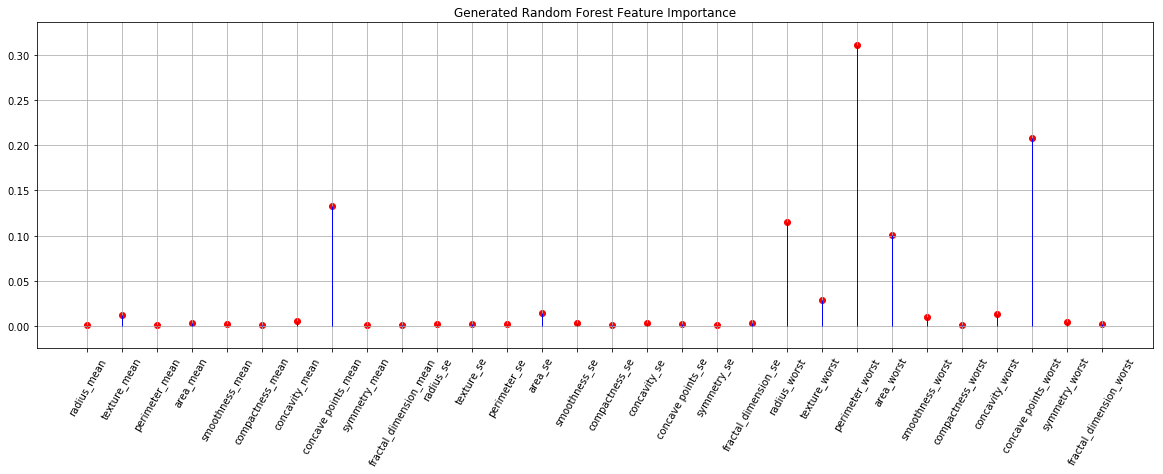

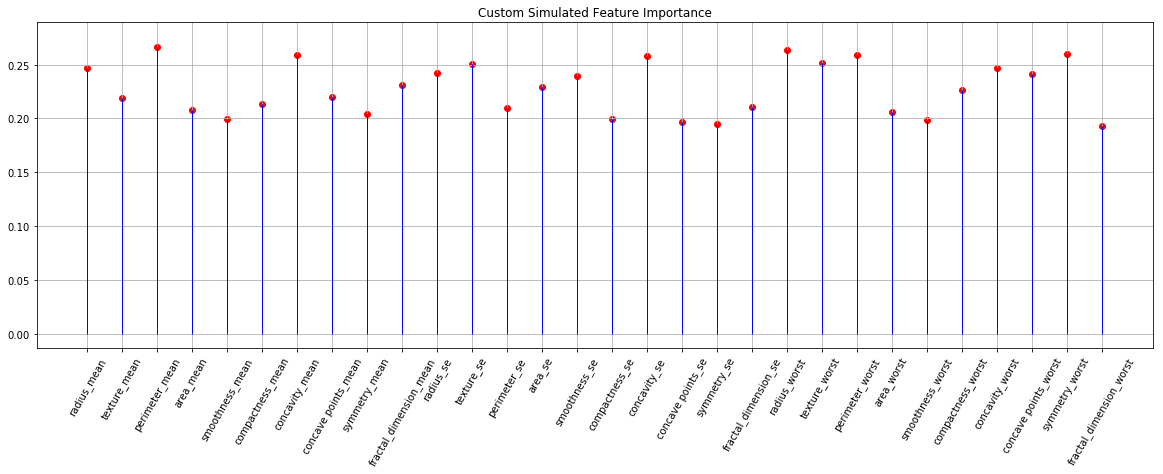

In [47]:
# Random Forest Feature Importances
plt.figure(figsize=(20,6))
plt.title('Generated Random Forest Feature Importance')
plt.scatter(range(DF.shape[1]),clf.feature_importances_,color='red')
plt.xticks(range(DF.shape[1]), DF.columns)
plt.vlines(range(DF.shape[1]),0,clf.feature_importances_,color = 'blue',lw=1)
plt.xticks(rotation=60)
plt.grid(which = 'both')
plt.show()

plt.figure(figsize=(20,6))
plt.title('Custom Simulated Feature Importance')
plt.scatter(range(DF.shape[1]),mean_purity,color='red')
plt.xticks(range(DF.shape[1]), DF.columns)
plt.vlines(range(DF.shape[1]),0,mean_purity,color = 'blue',lw=1)
#plt.ylim(0.2,0.25)
plt.xticks(rotation=60)
plt.grid(which = 'both')
plt.show()